# [自然语言处理入门](https://github.com/FudanNLP/nlp-beginner)

## 任务一：基于机器学习的文本分类

实现基于logistic/softmax regression的文本分类

1. 参考
   1. [文本分类](文本分类.md)
   2. 《[神经网络与深度学习](https://nndl.github.io/)》 第2/3章
2. 数据集：[Classify the sentiment of sentences from the Rotten Tomatoes dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)
3. 实现要求：NumPy
4. 需要了解的知识点：

   1. 文本特征表示：Bag-of-Word，N-gram
   2. 分类器：logistic/softmax  regression，损失函数、（随机）梯度下降、特征选择
   3. 数据集：训练集/验证集/测试集的划分
5. 实验：
   1. 分析不同的特征、损失函数、学习率对最终分类性能的影响
   2. shuffle 、batch、mini-batch 
6. 时间：两周

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1

basic-text-classification.ipynb  text-classification-nn.ipynb
data				 text-classification-rnn.ipynb


### 神经网络

In [ ]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# 读取 TSV 文件并转成 Dataset
def load_dataset(path):
  data = pd.read_csv(path, delimiter='\t', encoding='utf-8')
  return data

SENTIMENT_LABELS = [
    "negative", "somewhat negative", "neutral", "somewhat positive", "positive"
]

def add_readable_labels_column(df, sentiment_value_column):
  df["SentimentLabel"] = df[sentiment_value_column].replace(
      range(5), SENTIMENT_LABELS)

def get_data(train_file, test_file, validation_set_ratio=0.1):
  train_df = load_dataset(train_file)
  test_df = load_dataset(test_file)

  add_readable_labels_column(train_df, "Sentiment")

  train_indices, validation_indices = model_selection.train_test_split(
      np.unique(train_df["SentenceId"]),
      test_size=validation_set_ratio,
      random_state=0)

  validation_df = train_df[train_df["SentenceId"].isin(validation_indices)]
  train_df = train_df[train_df["SentenceId"].isin(train_indices)]
  print("Split the training data into %d training and %d validation examples." %
        (len(train_df), len(validation_df)))

  return train_df, validation_df, test_df

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [ ]:
TRAIN_FILE_PATH='/content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1/data/train.tsv'
TEST_FILE_PATH='/content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1/data/test.tsv'

# 读取文件
train_df, validation_df, test_df = get_data(TRAIN_FILE_PATH, TEST_FILE_PATH)


Split the training data into 140315 training and 15745 validation examples.


In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url).signatures['default']
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(500),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    phrases = inputs['Phrase'][:,0]
    embedding = 5*self.embed(phrases)['default']
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

In [ ]:
model = MyModel("https://tfhub.dev/google/nnlm-en-dim128/1")
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [ ]:
history = model.fit(x=dict(train_df), y=train_df['Sentiment'],
          validation_data=(dict(validation_df), validation_df['Sentiment']),
          epochs = 25)

Epoch 1/25
4385/4385 [==============================] - 24s 5ms/step - loss: 1.0627 - accuracy: 0.5701 - val_loss: 0.9917 - val_accuracy: 0.5870
Epoch 2/25
4385/4385 [==============================] - 23s 5ms/step - loss: 1.0028 - accuracy: 0.5941 - val_loss: 0.9873 - val_accuracy: 0.5980
Epoch 3/25
4385/4385 [==============================] - 23s 5ms/step - loss: 1.0009 - accuracy: 0.5945 - val_loss: 1.0068 - val_accuracy: 0.5774
Epoch 4/25
4385/4385 [==============================] - 23s 5ms/step - loss: 0.9926 - accuracy: 0.5984 - val_loss: 0.9865 - val_accuracy: 0.5889
Epoch 5/25
4385/4385 [==============================] - 23s 5ms/step - loss: 0.9896 - accuracy: 0.5972 - val_loss: 0.9844 - val_accuracy: 0.5963
Epoch 6/25
4385/4385 [==============================] - 23s 5ms/step - loss: 0.9904 - accuracy: 0.5995 - val_loss: 0.9834 - val_accuracy: 0.5937
Epoch 7/25
4385/4385 [==============================] - 23s 5ms/step - loss: 0.9899 - accuracy: 0.5995 - val_loss: 0.9807 - val_ac

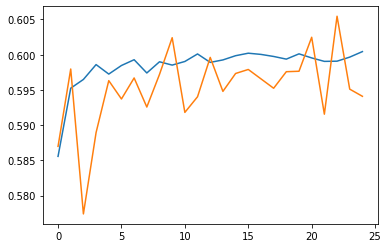

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
train_eval_result = model.evaluate(dict(train_df), train_df['Sentiment'])
validation_eval_result = model.evaluate(dict(validation_df), validation_df['Sentiment'])

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

493/493 [==============================] - 1s 2ms/step - loss: 0.9792 - accuracy: 0.5941
Training set accuracy: 0.6001639366149902
Validation set accuracy: 0.594093382358551


In [ ]:
predictions = model.predict(dict(validation_df))
predictions = tf.argmax(predictions, axis=-1)
predictions

<tf.Tensor: shape=(15745,), dtype=int64, numpy=array([1, 1, 2, ..., 2, 2, 2])>

In [ ]:
cm = tf.math.confusion_matrix(validation_df['Sentiment'], predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(32.99999999999999, 0.5, 'True')

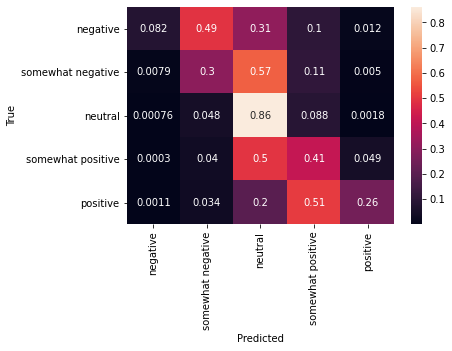

In [ ]:
sns.heatmap(
    cm, annot=True,
    xticklabels=SENTIMENT_LABELS,
    yticklabels=SENTIMENT_LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")